# **Solving 1D Diffusion Equation - Finite Difference vs Neural Network**
### ***#2: Discourse on Deep Learning Techniques for Engineering Physics***

https://adarshgouda.github.io/



---



## **Motivation**

The three main methods used to solve scientific equations and problems are analytical, numerical, and experimental. However, due to financial and time restrictions, we cannot always apply the experimental technique. Analytical techniques are the classic approaches to problem solving. However, we cannot solve equations analytically due to limitations imposed by complex geometry, boundary conditions, and other factors.

As a result, we have been encouraging numerical approaches for a number of years since they may generate answers that are virtually as trustworthy as those of analytical methods in a lot shorter and simpler amount of time. For instance, the well-known Navier-Stoke equation may be swiftly solved using Numerical Schemes even though it has never been analytically solved. The drawbacks of conventional numerical schemes, on the other hand, are their difficulty in expressing irregular borders, the fact that they are not designed for unstructured meshes, and the fact that momentum, energy, and mass are not conserved. Lastly, they are oriented toward edges and one-dimensional physics and are not well suited for substantial turbulent flow issues.

A revolutionary deep learning paradigm called physics informed neural networks (PINNs) is well suited for tackling forward and inverse issues of nonlinear partial differential equations (PDEs). Feedforward neural networks are trained as surrogate models for approximation solutions to the PDEs without the requirement for label data by including the physical information defined by PDEs in them. Numerous PINN-based approaches have been created to solve various types of problems, including integer-order PDEs, fractional PDEs, stochastic PDEs, and integro-differential equations. This is due to neural networks' great capacity to describe complicated connections (IDEs).

![A Typcial PINN Framework](https://drive.google.com/uc?export=view&id=1rrlQasTqngrtcDexpoZduDC0HGKW5lrl)


In this article, I investigate the usage of PINNs as a solution approximation for 1D Diffusion Equation. I first solve the equation using Finite Difference Method and the Solve the exact same equation using a PINN.



---



## **A Simple 1D Diffusion Equation:**

$$\frac{\partial u}{\partial t}= \nu \frac{\partial^2 u}{\partial x^2}$$

$$x\in[-1,1]$$
$$t\in[0,1]$$

$$\nu → Viscosity = 0.1 $$

### Initial Condition:

$$y(x,0)=sin(\pi x)$$

### Boundary Conditions:

$$y(-1,t)=0$$
$$y(1,t)=0$$








---



## **Finite Difference Method**

The second-order derivative $\frac{\partial ^2 u}{\partial x^2}$ can be represented geometrically as the line tangent to the curve given by the first derivative.  We will discretize the second-order derivative with a Central Difference scheme: a combination of Forward Difference and Backward Difference of the first derivative.  Consider the Taylor expansion of $u_{i+1}$ and $u_{i-1}$ around $u_i$:


$$u_{i+1} = u_i + \Delta x \frac{\partial u}{\partial x}\bigg|_i + \frac{\Delta x^2}{2} \frac{\partial ^2 u}{\partial x^2}\bigg|_i + \frac{\Delta x^3}{3!} \frac{\partial ^3 u}{\partial x^3}\bigg|_i + O(\Delta x^4)$$

$$u_{i-1} = u_i - \Delta x \frac{\partial u}{\partial x}\bigg|_i + \frac{\Delta x^2}{2} \frac{\partial ^2 u}{\partial x^2}\bigg|_i - \frac{\Delta x^3}{3!} \frac{\partial ^3 u}{\partial x^3}\bigg|_i + O(\Delta x^4)$$


If we add these two expansions, you can see that the odd-numbered derivative terms will cancel each other out.  If we neglect any terms of $O(\Delta x^4)$ or higher (and really, those are very small), then we can rearrange the sum of these two expansions to solve for our second-derivative.

$$u_{i+1} + u_{i-1} = 2u_i+\Delta x^2 \frac{\partial ^2 u}{\partial x^2}\bigg|_i + O(\Delta x^4)$$

Then rearrange to solve for $\frac{\partial ^2 u}{\partial x^2}\bigg|_i$ and the result is:

$$\frac{\partial ^2 u}{\partial x^2}=\frac{u_{i+1}-2u_{i}+u_{i-1}}{\Delta x^2} + O(\Delta x^2)$$

We can now write the discretized version of the diffusion equation in 1D:

$$\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\nu\frac{u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n}}{\Delta x^2}$$

Once we have an initial condition, the only unknown is $u_{i}^{n+1}$, so we re-arrange the equation solving for our unknown:

$$u_{i}^{n+1}=u_{i}^{n}+\frac{\nu\Delta t}{\Delta x^2}(u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n})$$



In [1]:
#! pip install pyDOE --quiet 
#We will use Latin Hypercube Sampling from this library

In [2]:
import torch                           # Pytorch
import torch.autograd as autograd      # computation graph
from torch import Tensor               
import torch.nn as nn                  # neural networks
import torch.optim as optim            # optimizers 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import pandas as pd

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
#torch.manual_seed(1234)

# Random number generators in other libraries
#np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("The device on which the code will run =>",device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())
    
%matplotlib inline 
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

The device on which the code will run => cuda


In [3]:
#A Helper function to plot the results in 3D

def plot3D(x,t,y):
    x_plot =x.squeeze(1) 
    t_plot =t.squeeze(1)
    X,T= torch.meshgrid(x_plot,t_plot,indexing='ij')
    u_xt = y
    fig = plt.figure()
    ax=fig.subplots(1,1)
    cp = ax.contourf(T,X,u_xt,20,cmap=cm.rainbow,vmin = -1., vmax = 1) #)levels = np.linspace(-1.0,1.0,12))
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('u')
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    plt.show()
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(T.numpy(), X.numpy(), u_xt.numpy(),cmap=cm.rainbow,vmin = -1, vmax = 1, antialiased=False)
    ax.set_xlabel('t')
    ax.set_ylabel('x')
    ax.set_zlabel('u')
    ax.set_zlim3d(-1, 1)
    plt.show()

In [4]:
#x∈[−1,1]
x_min=-1
x_max=1

#t∈[0,1]
t_min=0
t_max=1

#Discretization points for x and t

total_points_x=101
total_points_t=1000

dt = (t_max-t_min)/total_points_t
dx = (x_max-x_min)/(total_points_x-1)

viscosity = 0.1 # Given

dx,dt

(0.02, 0.001)

In [5]:
#Implementing Finite Difference Method to solve the 1D Diffusion Equation

def u_fem(x,t):
    un = np.ones(total_points_x)
    rec = np.zeros([total_points_x, total_points_t])
    
    for j in range(total_points_t):
        
        un = u.clone()
        
        for i in range(1,total_points_x-1):
            rec[i,j] = u[i]
            u[i] = un[i] + viscosity * (dt/dx**2) * (un[i+1]- 2*un[i] + un[i-1])
    
    return u, torch.from_numpy(rec)

In [6]:
# Creating descretized domains
x = torch.linspace(x_min, x_max, total_points_x).view(-1,1)
t = torch.linspace(t_min, t_max, total_points_t).view(-1,1)
x.shape, t.shape

(torch.Size([101, 1]), torch.Size([1000, 1]))

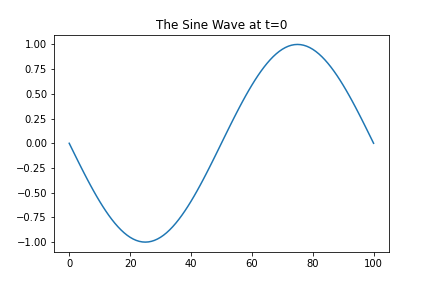

In [7]:
#Initial Condition: u(x,t)=sin(πx)

u = torch.from_numpy(np.sin(np.pi*x.numpy()))
u_plot = u.clone()
plt.plot(u_plot)
plt.title("The Sine Wave at t=0")
plt.show() 

In [8]:
# Meshgrid helps in creating all the combination of x and t points
# Implementing this will help in both 3D plotting and 
# later in setting up the dataset for training PINNs

X, T = torch.meshgrid(x.squeeze(1),t.squeeze(1), indexing='ij')
X.shape,T.shape

(torch.Size([101, 1000]), torch.Size([101, 1000]))

In [9]:
# Computing Finitie Difference solution for u

u_final, u_fem_2D = u_fem(x,t) 
assert u_fem_2D.shape == torch.Size([total_points_x, total_points_t]),f"Expected [{total_points_x},{total_points_t}], got {u_fem_2D.shape}"

## **Finite Difference Method - Solution**

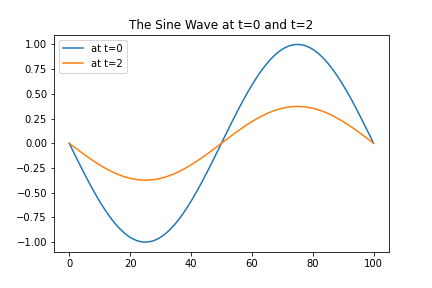

In [10]:
plt.plot(u_plot, label="at t=0")
plt.plot(u_final, label="at t=2")
plt.title("The Sine Wave at t=0 and t=2")
plt.legend()
plt.show()

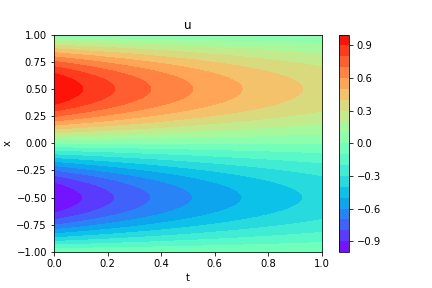

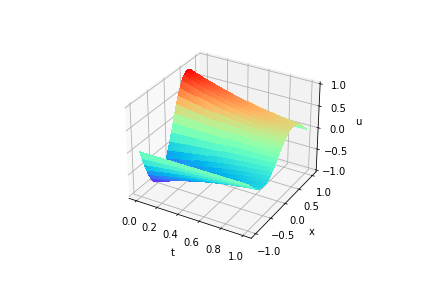

In [11]:
plot3D(x,t,u_fem_2D)

Notice that as time approached 2, the amplitude has significatly diminished. Which is as expected from a Diffusion equation. Note that, the equation is in faact 1D. The 3D plot above is for better visualition of how a Sine wave amplitude diffuses over time.



---



## **Physics Informed Neural Network**

If we rearrange our PDE, we get:

$$\left(\frac{\partial y}{\partial t} - \nu\frac{\partial^2 y}{\partial x^2}\right)=0$$

## Neural Network

A Neural Network is a function approximator constructed as follows:

$$NN(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

**Note:**We usually train our NN by iteratively minimizing a loss function ($MSE$:mean squared error) in the training dataset(known data).

## PINNs = Neural Network + PDE 

We can use a neural network to approximate any function (Universal APproximation Theorem):
$$NN(x,t)\approx y(x,t)$$ 

Since NN is a function, we can obtain its derivatives: $\frac{\partial NN}{\partial t},\frac{\partial^2 NN}{\partial x^2}$.(Automatic Diferentiation) 

Assume:$$NN(t,x)\approx y(t,x)$$ 

Then:

$$\left(\frac{\partial NN}{\partial t} -\nu\frac{\partial^2 NN}{\partial x^2}
\right)\approx \left(\frac{\partial y}{\partial t} -\nu\frac{\partial^2 y}{\partial x^2}\right)=0$$

And:

$$\left(\frac{\partial NN}{\partial t} -\nu\frac{\partial^2 NN}{\partial x^2}
\right)\approx 0$$


We define this function as $f$:

$$f(t,x)=\left(\frac{\partial NN}{\partial t} -\nu\frac{\partial^2 NN}{\partial x^2}\right)\rightarrow residue$$

If $residue\rightarrow 0$ then our NN would be respecting the physical law. To minimize the $residue$ we will use L2 norm with matrix of zeros with same size as the $residue$

### PINNs' Loss function

We evaluate our PDE in a certain number of "collocation points" ($N_f$) inside our domain $(x,t)$. Then we iteratively minimize a loss function related to $f$:

$$MSE_f=\frac{1}{N_f}\sum^{N_f}_{i=1}|f(t_f^i,x_f^i)|^2$$

Usually, the training data set is a set of points from which we know the answer. In our case, we will use our boundary(BC) and initial conditions(IC).

#### Initial Condition:

$$y(x,0)=sin(\pi x)$$

#### Boundary Conditions:

$$y(-1,t)=0$$
$$y(1,t)=0$$

Since we know the outcome, we select $N_u$ points from our BC and IC and used them to train our network.

$$MSE_{u}=\frac{1}{N_u}\sum^{N_u}_{i=1}|y(t_{u}^i,x_u^i)-NN(t_{u}^i,x_u^i)|^2$$


#### Total Loss:

$$MSE=MSE_{u}+MSE_f$$

In [12]:
# Creating same amount of grid lattice as FDM
x = torch.linspace(x_min, x_max, total_points_x).view(-1,1)
t = torch.linspace(t_min, t_max, total_points_t).view(-1,1)
x.shape, t.shape

(torch.Size([101, 1]), torch.Size([1000, 1]))

In [13]:
X, T = torch.meshgrid(x.squeeze(1),t.squeeze(1), indexing='ij') #same as FDM
X.shape, T.shape

(torch.Size([101, 1000]), torch.Size([101, 1000]))

In [14]:
#Initial Condition: u(x,t)=sin(πx). However, we are using MeshGrid to provide us all combinations of x and t

# At u(X,T=0)=sin(pi*X), T=0 is given by T[:,0] in the meshgrid which points to corresponding X[:,0]

left_X = torch.hstack((X[:,0][:,None], T[:,0][:,None])) #horizontal staking to create X, T dataset 
left_U = torch.sin(np.pi*left_X[:,0]).unsqueeze(1)

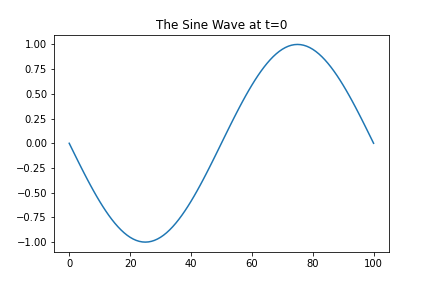

In [15]:
plt.plot(left_U) 
plt.title("The Sine Wave at t=0")
plt.show()
#This is the initail condition of the sine wave with amplitude 1
#As time passes, the sin wave will "diffuse" and its amplitude diminishes 
#As you saw in the FDM simulation, the amplitude dropped down to about 0.1 at T=t_max=1
#We should expect the same behavior from PINNs

In [16]:
#Boundary Conditions
#There are two boundaries at x=x_min and x=x_max. At any given time t, the u(x=x_min, t) = u(x=x_max,t) = 0

# BC at x_min
bottom_X = torch.hstack((X[0,:][:,None],T[0,:][:,None]))
bottom_U = torch.zeros(bottom_X.shape[0],1)

# BC at x_max
top_X = torch.hstack((X[-1,:][:,None],T[-1,:][:,None]))
top_U = torch.zeros(top_X.shape[0],1)

In [17]:
#Now we will stack it all in a vstack to get a dataset [x,t] and corresponding y=u(x,t) will be sampled later to create a train set

X_train = torch.vstack([left_X, bottom_X, top_X])
U_train = torch.vstack([left_U, bottom_U, top_U])

X_train.shape

torch.Size([2101, 2])

In [18]:
N_bc = 1000 #Number of points on IC and BC
N_pde = 30000 #Number of points on PDE domain (Collocation Points)

#Now we will sample N_bc points at random 
#from the X_train, U_train dataset

idx = np.random.choice(X_train.shape[0],N_bc, replace=False)
X_train_sampled = X_train[idx,:]
U_train_sampled = U_train[idx,:]

#The boundary conditions will not change. 
#Hence, these U values can be used as supervised labels during training

#For PDE collocation points, we will generate new X_train_pde dataset
#We do not know U(X,T) for these points 

#Lets get the entire X,T dataset in a format suitable for Neural Network
#We will later use this for testing NN as well. So, lets call this x_test for convenience

x_test = torch.hstack((X.transpose(1,0).flatten()[:,None],
                       T.transpose(1,0).flatten()[:,None])) 

#We need column major flattening to simlulte time-marching. Hence the transpose(1,0) or simply use .T

#we will use U generated from FEM as our u_test 
#We will use u_test later in the process for calculating NN performance

u_test = u_fem_2D.transpose(1,0).flatten()[:,None]
x_test.shape

torch.Size([101000, 2])

In [19]:
#lower and upper bounds of x_test
lb = x_test[0]
ub = x_test[-1]
lb,ub

(tensor([-1.,  0.]), tensor([1., 1.]))

In [20]:
#Sampling (X,T) domain using LHS
lhs_samples = lhs(2,N_pde) 
#2 since there are 2 variables in X_train, [x,t]
lhs_samples.shape

(30000, 2)

In [21]:
X_train_lhs = lb + (ub-lb)*lhs_samples
X_train_lhs.shape

torch.Size([30000, 2])

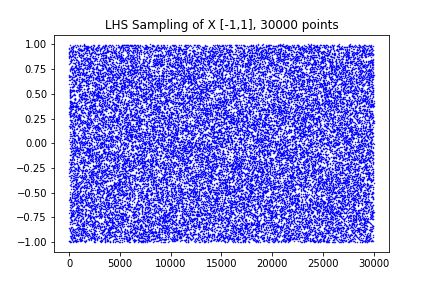

In [22]:
plt.plot(pd.DataFrame(X_train_lhs)[0], "bo", markersize=.5)
plt.title("LHS Sampling of X [-1,1], 30000 points")
plt.show()

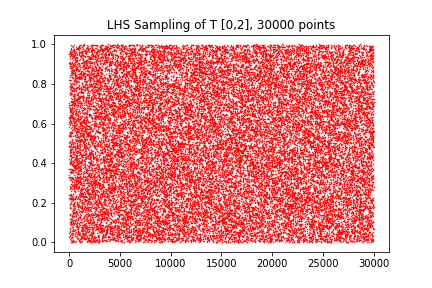

In [23]:
plt.plot(pd.DataFrame(X_train_lhs)[1], "ro", markersize=.5)
plt.title("LHS Sampling of T [0,2], 30000 points")
plt.show()

For the above two plots, its clear that LHS provides a near-random disctribution of points. This is what we need.

In [24]:
X_train_final = torch.vstack((X_train_lhs, X_train_sampled))
X_train_final.shape #30000 from pde + 1000 from bc

torch.Size([31000, 2])

In [25]:
#Lets define a u_NN

class u_NN(nn.Module):
    
    def __init__(self, layers_list):
        
        super().__init__()

        self.depth = len(layers_list)

        self.loss_function = nn.MSELoss(reduction="mean")
    
        self.activation = nn.Tanh() #This is important, ReLU wont work

        self.linears = nn.ModuleList([nn.Linear(layers_list[i],layers_list[i+1]) for i in range(self.depth-1)])

        for i in range(self.depth-1):
      
          nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0) #xavier normalization of weights
      
          nn.init.zeros_(self.linears[i].bias.data) #all biases set to zero 

    def Convert(self, x): #helper function
        
        if torch.is_tensor(x) !=True:
            x = torch.from_numpy(x)
        return x.float().to(device)
  
    def forward(self, x):
        
        a = self.Convert(x)

        for i in range(self.depth-2):
            z = self.linears[i](a)
            a = self.activation(z)
        
        a = self.linears[-1](a)

        return a

    def loss_bc(self, x_bc, u_bc):
        # We'll pass X_train_sampled and U_train_sampled here. This is similar to a Supervised Learning

        l_bc = self.loss_function(self.forward(self.Convert(x_bc)), self.Convert(u_bc)) #L2 loss

        return l_bc

    def loss_pde(self, x_pde):
        # We will pass x_train_final here. 
        # Note that we do not have U_pde (labels) here to calculate loss. This is not Supervised Learning. 
        # Here we want to minimize the residues. So, we will first calculate the residue and then minimize it to be close to zero.
        
        x_pde = self.Convert(x_pde)

        x_pde_clone = x_pde.clone() ##VERY IMPORTANT
    
        x_pde_clone.requires_grad = True #enable Auto Differentiation

        NN = self.forward(x_pde_clone) #Generates predictions from u_NN

        NNx_NNt = torch.autograd.grad(NN, x_pde_clone,self.Convert(torch.ones([x_pde_clone.shape[0],1])),retain_graph=True, create_graph=True)[0] #Jacobian of dx and dt

        NNxx_NNtt = torch.autograd.grad(NNx_NNt,x_pde_clone, self.Convert(torch.ones(x_pde_clone.shape)), create_graph=True)[0] #Jacobian of dx2, dt2

        NNxx = NNxx_NNtt[:,[0]] #Extract only dx2 terms

        NNt = NNx_NNt[:,[1]] #Extract only dt terms
    
        # {(du/dt) = viscosity * (d2u/dx2)} is the pde and the NN residue will be {du_NN/dt - viscosity*(d2u_NN)/dx2} which is == {NNt - viscosity*NNxx}

        residue = NNt - viscosity*NNxx 

        # The residues need to be zero (or as low as possible). We'll create an arrazy of Zeros and minimize the residue 

        zeros = self.Convert(torch.zeros(residue.shape[0],1))

        l_pde = self.loss_function(residue, zeros) #L2 Loss

        return l_pde
    
    def total_loss(self, x_bc, u_bc, x_pde): #Combine both loss
        l_bc = self.loss_bc(x_bc, u_bc)
        l_pde = self.loss_pde(x_pde)
        return l_bc + l_pde #this HAS to be a scalar value for auto differentiation to do its thing.


In [26]:
#Parameters for u_NN

EPOCHS = 30000
lr = 1e-4
layers_list = [2, 32, 128, 16, 128, 32, 1] 

# Instantiate a model

PINN = u_NN(layers_list).to(device)
print(PINN)

optimizer = torch.optim.Adam(PINN.parameters(), lr=lr,amsgrad=False)


u_NN(
  (loss_function): MSELoss()
  (activation): Tanh()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=128, bias=True)
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [27]:
print("Original shapes for X and Y:",X.shape,u_fem_2D.shape)
print("Boundary shapes for the edges:",left_X.shape, bottom_X.shape,top_X.shape)
print("Available training data:",X_train.shape,U_train.shape)
print("Final training data:",X_train_sampled.shape,U_train_sampled.shape)
print("Total collocation points:",X_train_final.shape)

# Make sure that the Sizes are all good and they add up

Original shapes for X and Y: torch.Size([101, 1000]) torch.Size([101, 1000])
Boundary shapes for the edges: torch.Size([101, 2]) torch.Size([1000, 2]) torch.Size([1000, 2])
Available training data: torch.Size([2101, 2]) torch.Size([2101, 1])
Final training data: torch.Size([1000, 2]) torch.Size([1000, 1])
Total collocation points: torch.Size([31000, 2])


In [28]:
#****** Training ******#

for i in range(EPOCHS):
    if i==0:
        print("BC Loss \t PDE Loss \t Total Loss \t Test Loss")
        
    l_bc = PINN.loss_bc(X_train_sampled,U_train_sampled)
    l_pde = PINN.loss_pde(X_train_final)
    loss = PINN.total_loss(X_train_sampled, U_train_sampled, X_train_final)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    if i%(EPOCHS/10)==0:
        with torch.no_grad():
            test_loss = PINN.loss_bc(x_test,u_test) #Here we are using loss_bc method as a helper function to calculate L2 loss
            
            print(format(l_bc.detach().cpu().numpy(),".4E"),'\t',format(l_pde.detach().cpu().numpy(),".4E"),'\t',format(loss.detach().cpu().numpy(),".4E"),'\t',format(test_loss.detach().cpu().numpy(),".4E"))

BC Loss 	 PDE Loss 	 Total Loss 	 Test Loss
2.5894E-02 	 8.1860E-03 	 3.4081E-02 	 2.3665E-01
2.4012E-04 	 1.2097E-04 	 3.6108E-04 	 3.3227E-03
1.1917E-04 	 5.8292E-05 	 1.7746E-04 	 2.6861E-03
6.3352E-05 	 3.0961E-05 	 9.4313E-05 	 2.5060E-03
3.6021E-05 	 2.1521E-05 	 5.7542E-05 	 2.4278E-03
2.4698E-05 	 1.7050E-05 	 4.1748E-05 	 2.2739E-03
1.4630E-05 	 1.0056E-05 	 2.4686E-05 	 2.3117E-03
1.4032E-05 	 1.0946E-05 	 2.4979E-05 	 2.1838E-03
1.2381E-05 	 8.1552E-06 	 2.0536E-05 	 2.4266E-03
1.4163E-05 	 1.1582E-05 	 2.5746E-05 	 2.2351E-03


## **Neural Network - Solution**

In [29]:
# Predictions from the NN

u_NN_predict = PINN(x_test)

In [30]:
#Segregating x and t

x_=x_test[:,0][:,None]
t_=x_test[:,1][:,None]

In [31]:
#Reshapping y1 to be used in plot3d()

u_NN_2D = u_NN_predict.reshape(shape=[total_points_t,total_points_x]).transpose(1,0).detach().cpu()

assert u_NN_2D.shape == torch.Size([total_points_x, total_points_t]),f"Expected [{total_points_x},{total_points_t}], got {u_NN_2D.shape}"

3D plot of solution for U based on Neural Network (PINN)

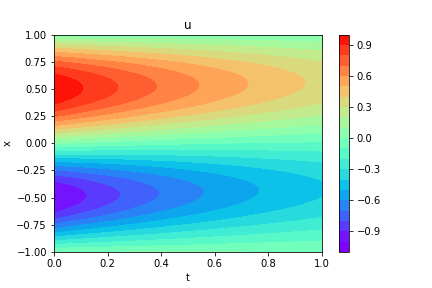

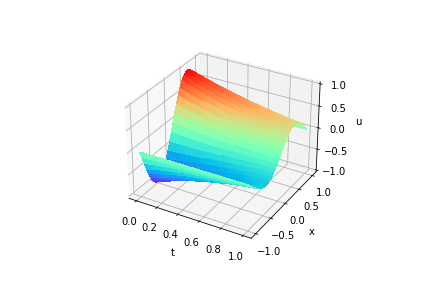

In [32]:
plot3D(x,t,u_NN_2D)

3D plot of solution for U based on Finite Difference Method computed earlier.

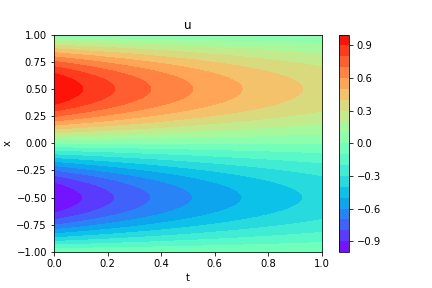

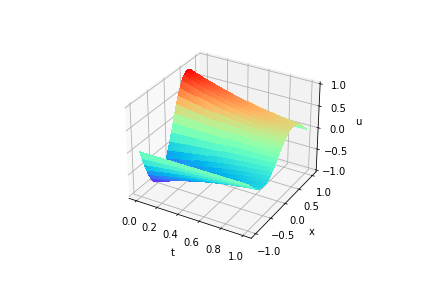

In [33]:
plot3D(x,t,u_fem_2D) 

3D plot of solution for Difference between both solutions

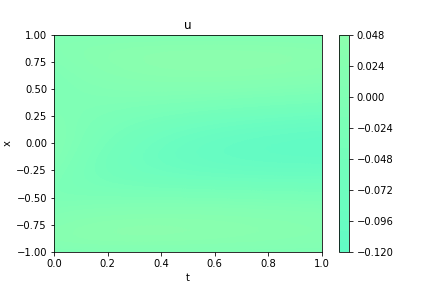

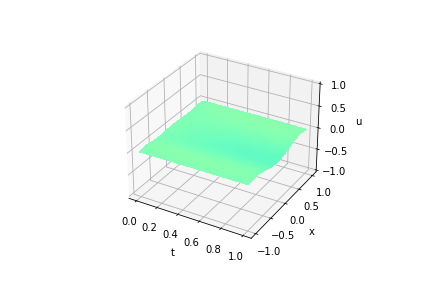

In [34]:
plot3D(x,t,(u_NN_2D - u_fem_2D)) #Error

The RMSE Error between both solutions

In [35]:
RMSE = torch.sqrt(torch.mean(torch.square(torch.subtract(u_NN_2D,u_fem_2D))))

print("The RMSE error between FDM and PINN is :",np.around(RMSE.item(),5))

The RMSE error between FDM and PINN is : 0.04786


## **Conclusion**

Clearly, PINNs can approximate the 1D Diffusion PDE pretty accurately. Further study is necessary to improve the accuray. Also notice the slight skew in the wave pattern starting from t=1. The root cause needs to be further investigated. In the next discussion, we will consider Burgers Equation and eventually develope a PINN model for the complete Navier-Stokes Equation.

![Final Results](https://drive.google.com/uc?export=view&id=1lbbrLT31jiJ9tr2pGLsGH7FWS8IYSos0)

## **References**

[1] Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations. arXiv preprint arXiv:1711.10561. http://arxiv.org/pdf/1711.10561v1

[2] https://www.uni-muenster.de/imperia/md/content/physik_tp/lectures/ws2016-2017/num_methods_i/heat.pdf

[3] http://hplgit.github.io/num-methods-for-PDEs/doc/pub/diffu/html/._diffu001.html

[4] Rackauckas Chris, Introduction to Scientific Machine Learning through Physics-Informed Neural Networks. https://book.sciml.ai/notes/03/

[5] https://github.com/jdtoscano94/Learning-Python-Physics-Informed-Machine-Learning-PINNs-DeepONets

[6] Kashefi, Ali and Tapan Mukerji. “Physics-informed PointNet: A deep learning solver for steady-state incompressible flows and thermal fields on multiple sets of irregular geometries.” J. Comput. Phys. 468 (2022): 111510.